# fig_rq5_amazon_platforms

Compare RQ5 (delta/iceberg) with RQ1 (hudi) across layouts for the same queries.


In [1]:
# --- Bootstrap paths so imports work both inside/outside VS Code ---
import sys
from pathlib import Path

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

NB_DIR = Path.cwd()           # current working dir (likely .../notebooks)
PROJ_ROOT = NB_DIR.parent     # project root (one level up)

for p in (NB_DIR, PROJ_ROOT):
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))

try:
    %load_ext autoreload
    %autoreload 2
except Exception:
    pass

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from viz_results_toolkit import plot_box, savefig_multi
from scripts.parse_tpch_results import (
    collect_amazon_rq1_results,
    collect_amazon_rq5_results,
    query_results_dataframe,
)

out_dir = PROJ_ROOT / "viz_out_results"
out_dir.mkdir(parents=True, exist_ok=True)


In [2]:
# --- Plotting constants and helper ---

LAYOUT_ORDER = ["no_layout", "linear", "zorder", "hilbert"]
ENGINE_ORDER = ("delta", "hudi", "iceberg")
BLOCK_GAP = 0.9
RQ1_DEFAULT_SCENARIO = "amazon_default"
RQ5_DEFAULT_SCENARIO = "amazon_default"
DEFAULT_COLUMN_CONFIG = ["C1"]
DATASET_LABEL = "amazon"


def _normalize_layouts(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "layout" not in df.columns:
        df["layout"] = None
    df["layout"] = df["layout"].fillna("baseline")
    df["layout"] = df["layout"].replace({"baseline": "no_layout"})
    return df


def _normalize_engine(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "engine" in df.columns:
        df["engine"] = df["engine"].astype(str).str.lower()
    else:
        df["engine"] = "unknown"
    return df


def load_rq1_rq5_query_data(
    query_id,
    *,
    rq1_collection,
    rq5_collection,
    rq1_scenario=RQ1_DEFAULT_SCENARIO,
    rq5_scenario=RQ5_DEFAULT_SCENARIO,
    selectivity_filter=None,
    column_config_filter=None,
    layout_order=None,
) -> pd.DataFrame:
    layout_order = layout_order or LAYOUT_ORDER
    column_config_filter = column_config_filter or DEFAULT_COLUMN_CONFIG

    df_rq1 = query_results_dataframe(rq1_collection, query_id)
    if rq1_scenario:
        df_rq1 = df_rq1[df_rq1["scenario_name"] == rq1_scenario]
    if selectivity_filter:
        df_rq1 = df_rq1[df_rq1["selectivity_label"].isin(selectivity_filter)].copy()
    if column_config_filter:
        df_rq1 = df_rq1[df_rq1["column_config"].isin(column_config_filter)].copy()
    df_rq1 = _normalize_layouts(_normalize_engine(df_rq1))
    df_rq1 = df_rq1[df_rq1["layout"].isin(layout_order)]

    df_rq5 = query_results_dataframe(rq5_collection, query_id)
    if rq5_scenario:
        df_rq5 = df_rq5[df_rq5["scenario_name"] == rq5_scenario]
    if selectivity_filter:
        df_rq5 = df_rq5[df_rq5["selectivity_label"].isin(selectivity_filter)].copy()
    if column_config_filter:
        df_rq5 = df_rq5[df_rq5["column_config"].isin(column_config_filter)].copy()
    df_rq5 = _normalize_layouts(_normalize_engine(df_rq5))
    df_rq5 = df_rq5[df_rq5["layout"].isin(layout_order)]

    if df_rq1.empty and df_rq5.empty:
        return pd.DataFrame()
    return pd.concat([df_rq1, df_rq5], ignore_index=True)


def plot_rq5_platform_grid(
    queries,
    *,
    rq1_collection,
    rq5_collection,
    rq1_scenario=RQ1_DEFAULT_SCENARIO,
    rq5_scenario=RQ5_DEFAULT_SCENARIO,
    selectivity_filter=None,
    column_config_filter=None,
    layout_order=None,
    metric="bytes_scanned_ev",
    log_scale=False,
    log_zero_fill=1,
    save=True,
    save_dir=None,
    filename_prefix=None,
    filename=None,
    save_formats=("png", "pdf"),
):
    if not queries:
        raise ValueError("Provide at least one query id")
    layout_order = layout_order or LAYOUT_ORDER
    column_config_filter = column_config_filter or DEFAULT_COLUMN_CONFIG

    frames = []
    for query_id in queries:
        dfq = load_rq1_rq5_query_data(
            query_id,
            rq1_collection=rq1_collection,
            rq5_collection=rq5_collection,
            rq1_scenario=rq1_scenario,
            rq5_scenario=rq5_scenario,
            selectivity_filter=selectivity_filter,
            column_config_filter=column_config_filter,
            layout_order=layout_order,
        )
        if dfq.empty:
            print(f'[warn] no rows for {query_id} after filters')
            continue
        dfq = dfq.copy()
        dfq["query_id"] = query_id
        if log_scale:
            dfq[metric] = np.where(dfq[metric] <= 0, log_zero_fill, dfq[metric])
        frames.append(dfq)

    if not frames:
        raise ValueError('No query produced data; adjust filters')

    df_all = pd.concat(frames, ignore_index=True)
    titles = list(df_all["query_id"].unique())
    n = len(titles)
    ncols = 4
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4 * nrows), squeeze=False)

    for idx, q in enumerate(titles):
        r, c = divmod(idx, ncols)
        ax = axes[r][c]
        dfq = df_all[df_all["query_id"] == q]
        plot_box(
            dfq,
            metric=metric,
            group_cols=("engine", "layout"),
            title=q,
            ax=ax,
            block_col="engine",
            blocks_order=ENGINE_ORDER,
            block_gap=BLOCK_GAP,
        )
        if log_scale:
            ax.set_yscale('log')

    for k in range(n, nrows * ncols):
        r, c = divmod(k, ncols)
        axes[r][c].axis('off')

    fig.tight_layout()
    if save:
        base_dir = Path(save_dir) if save_dir else out_dir
        base_dir.mkdir(parents=True, exist_ok=True)
        default_prefix = f"rq5_{DATASET_LABEL}_platforms_{metric}"
        stem_value = filename or filename_prefix or default_prefix
        stem_path = Path(str(stem_value))
        base_name = stem_path.stem if stem_path.suffix else stem_path.name
        fmt_list = [stem_path.suffix.lstrip('.')] if stem_path.suffix else save_formats
        if isinstance(fmt_list, str):
            fmt_list = [fmt_list]
        saved_paths = []
        for fmt in fmt_list:
            ext = fmt.lstrip('.')
            out_path = base_dir / f"{base_name}.{ext}"
            fig.savefig(out_path, bbox_inches="tight", pad_inches=0.02)
            saved_paths.append(out_path)
        print("saved:", ", ".join(str(p) for p in saved_paths))
    return fig, df_all


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq5_amazon_platforms_Q1_Q2_S4_bytes_scanned_ev.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq5_amazon_platforms_Q1_Q2_S4_bytes_scanned_ev.pdf


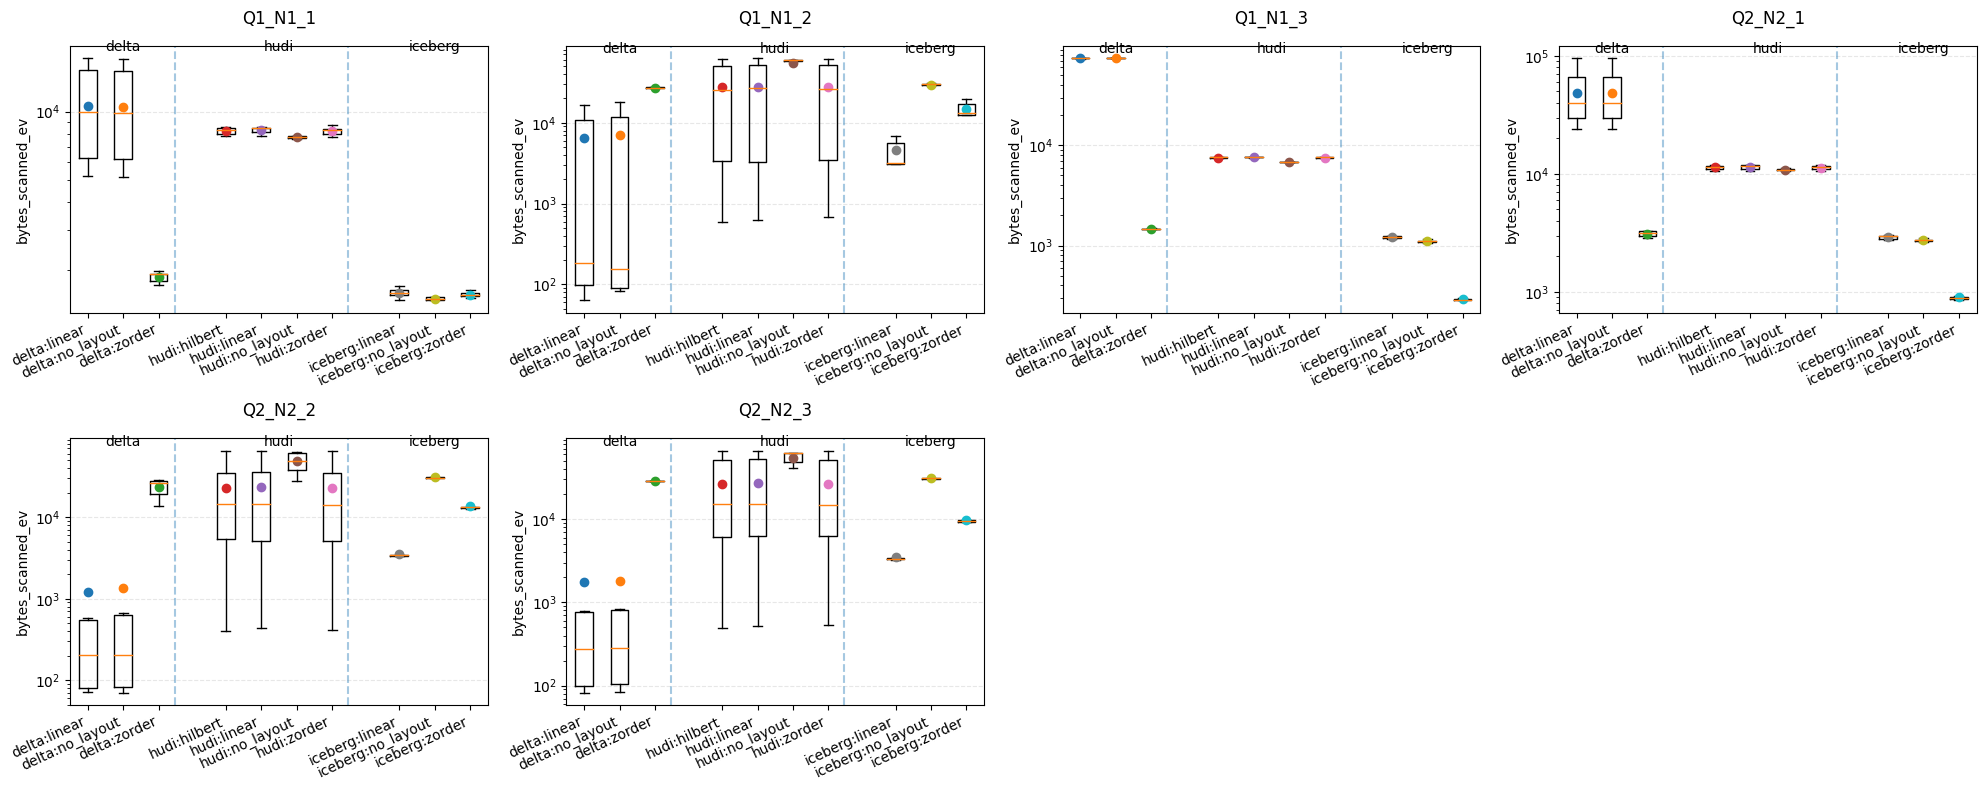

In [3]:
# Example: Q1/Q2 range queries (C1)
RQ5_RANGE_QUERIES = ['Q1_N1_1', 'Q1_N1_2', 'Q1_N1_3', 'Q2_N2_1', 'Q2_N2_2', 'Q2_N2_3']

rq1_collection = collect_amazon_rq1_results()
rq5_collection = collect_amazon_rq5_results()

fig, _ = plot_rq5_platform_grid(
    RQ5_RANGE_QUERIES,
    rq1_collection=rq1_collection,
    rq5_collection=rq5_collection,
    selectivity_filter=["S4"],
    column_config_filter=DEFAULT_COLUMN_CONFIG,
    metric="bytes_scanned_ev",
    log_scale=True,
    log_zero_fill=1,
    filename="rq5_amazon_platforms_Q1_Q2_S4_bytes_scanned_ev",
)


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq5_amazon_platforms_Q3_S0_bytes_scanned_ev.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq5_amazon_platforms_Q3_S0_bytes_scanned_ev.pdf


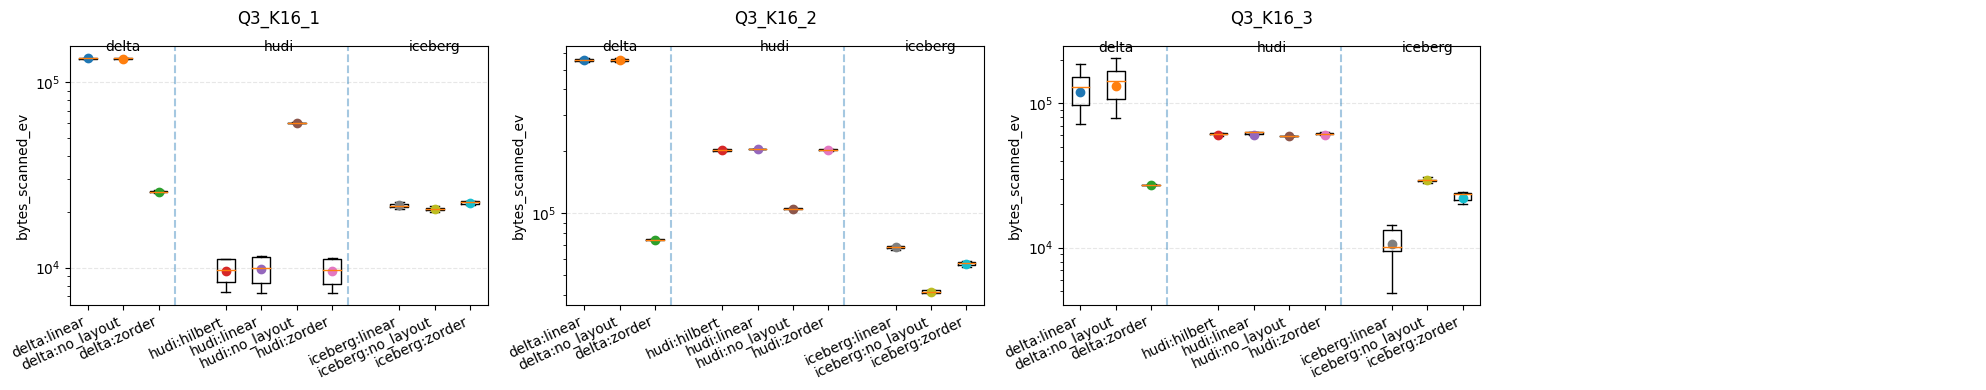

In [4]:
# Example: Q3 point queries (K=16)
RQ5_POINT_QUERIES = ['Q3_K16_1', 'Q3_K16_2', 'Q3_K16_3']

fig, _ = plot_rq5_platform_grid(
    RQ5_POINT_QUERIES,
    rq1_collection=rq1_collection,
    rq5_collection=rq5_collection,
    selectivity_filter=["S0"],
    column_config_filter=DEFAULT_COLUMN_CONFIG,
    metric="bytes_scanned_ev",
    log_scale=True,
    log_zero_fill=1,
    filename="rq5_amazon_platforms_Q3_S0_bytes_scanned_ev",
)
